In [21]:
import anki_vector
import time
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
## Testing if the Robot config is setup

# with anki_vector.Robot() as robot:
#     robot.anim.play_animation_trigger("GreetAfterLongTime")

20:14:51.811               robot.Robot WARNING  No serial number or name provided. Automatically selecting 00603a88
20:14:51.813     connection.Connection    INFO  Connecting to 192.168.0.31:443 for Vector-E6N5 using /home/darsh/.anki_vector/Vector-E6N5-00603a88.cert
20:14:52.268     connection.Connection    INFO  BehaviorControl control_granted_response { }


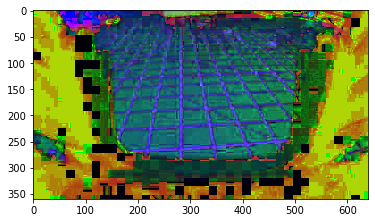

In [10]:
robot = anki_vector.Robot()
robot.connect()
robot.camera.init_camera_feed()
robot.motors.set_head_motor(-5.0) # move head to look at ground
time.sleep(1)
robot.motors.set_wheel_motors(10, 10) # set initial driving direction

imageFromVector = robot.camera.latest_image
frame = np.array(imageFromVector.raw_image)
image = cv2.cvtColor(np.array(imageFromVector.raw_image),cv2.COLOR_BGR2HSV) #convert image to gray
# image = np.array(imageFromVector.raw_image)
plt.imshow(image)
plt.show()
cv2.waitKey(3)


robot.disconnect()

### Thresholding to generate floor mask

In [23]:
`lower_thres = np.array([10,50,60])
upper_thres = np.array([70,175,200])
frame = np.array(imageFromVector.raw_image)
mask = cv2.inRange(image, lower_thres, upper_thres)
res = cv2.bitwise_and(frame,frame, mask= mask)

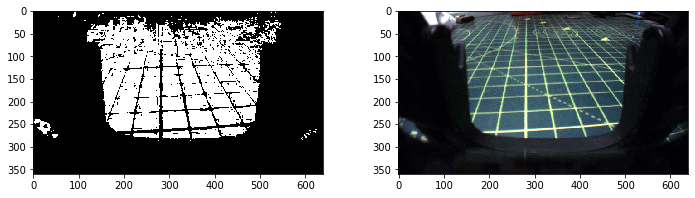

In [29]:
fig = plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.imshow(mask, cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(frame)


#### Image points of square grid for Perspective transform

<IPython.core.display.Javascript object>


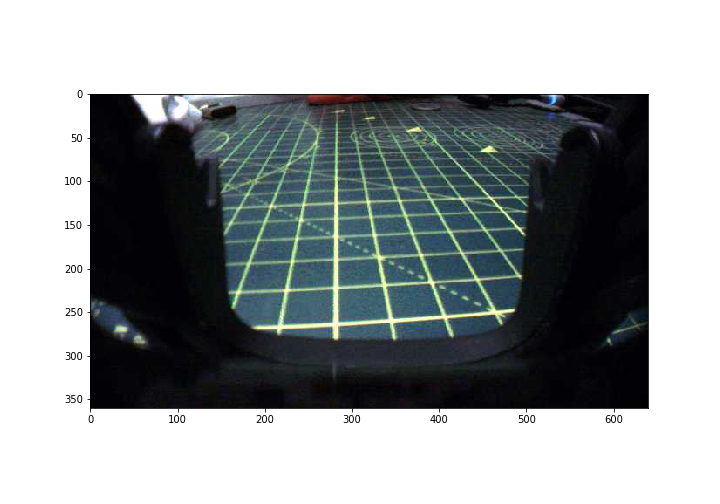

In [41]:
%matplotlib notebook

fig = plt.figure(figsize=(10,7))
plt.imshow(frame)
plt.show()

Coorinates of Lower left corner in counter clockwise direction:  
(285, 260)  
(342, 257)  
(335, 221)  
(285, 223) 

Coordinates of grid in world frame:  
(13, 10)  
(14, 10)  
(14, 11)  
(13, 11)  

### Perform perspective transform

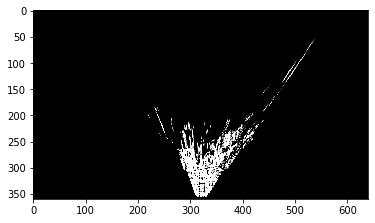

In [82]:
%matplotlib inline


def perspect_transform(img, src, dst):
    # Get transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

dst_size = 2
bottom_offset = 6



img_points = np.float32([[285, 260], [342, 257], [335, 221], [285, 223]])
# world_points = np.float32([[50, 5], [51, 5], [51, 6], [50, 6]])*5
world_points = np.float32([[frame.shape[1]/2 - dst_size, frame.shape[0] - bottom_offset],
                  [frame.shape[1]/2 + dst_size, frame.shape[0] - bottom_offset],
                  [frame.shape[1]/2 + dst_size, frame.shape[0] - 2*dst_size - bottom_offset], 
                  [frame.shape[1]/2 - dst_size, frame.shape[0] - 2*dst_size - bottom_offset],
                  ])

warped_image = perspect_transform(mask, img_points, world_points)
plt.imshow(warped_image, cmap = 'gray')
plt.show() 

#### Convert coordinates from Image coordinate system to Vector's coorinate frame

Text(0.5, 1.0, 'Rover-Centric Map')

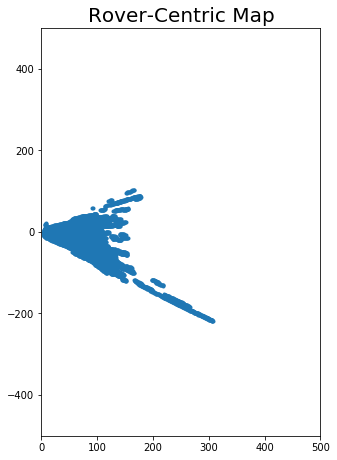

In [86]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

xpix, ypix = rover_coords(warped_image)

# Plot the map in rover-centric coords
fig = plt.figure(figsize=(5, 7.5))
plt.plot(xpix, ypix, '.')
plt.ylim(-500, 500)
plt.xlim(0, 500)
plt.title('Rover-Centric Map', fontsize=20)
#plt.show() # Uncomment if running on your local machine

To obtain vector's pose,  
https://developer.anki.com/vector/docs/generated/anki_vector.html#anki_vector.Robot.pose  

current_robot_pose = robot.pose
current_pose_angle_rad = robot.pose_angle_rad


In [9]:
robot.disconnect()